<a href="https://colab.research.google.com/github/june12mayank/Notebooks/blob/master/machinehack_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import datetime as dt

# Visualization libaries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine Learning
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [0]:
!wget https://www.machinehack.com/wp-content/uploads/2019/03/Flight_Ticket_Participant_Datasets-20190305T100527Z-001.zip

--2019-03-10 11:15:51--  https://www.machinehack.com/wp-content/uploads/2019/03/Flight_Ticket_Participant_Datasets-20190305T100527Z-001.zip
Resolving www.machinehack.com (www.machinehack.com)... 107.180.71.20
Connecting to www.machinehack.com (www.machinehack.com)|107.180.71.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 641764 (627K) [application/zip]
Saving to: ‘Flight_Ticket_Participant_Datasets-20190305T100527Z-001.zip’

Flight_Ticket_Parti 100%[===================>] 626.72K   636KB/s    in 1.0s    

2019-03-10 11:15:52 (636 KB/s) - ‘Flight_Ticket_Participant_Datasets-20190305T100527Z-001.zip’ saved [641764/641764]



In [0]:
!unzip /content/Flight_Ticket_Participant_Datasets-20190305T100527Z-001.zip

Archive:  /content/Flight_Ticket_Participant_Datasets-20190305T100527Z-001.zip
  inflating: Flight_Ticket_Participant_Datasets/Sample_submission.xlsx  
  inflating: Flight_Ticket_Participant_Datasets/Data_Train.xlsx  
  inflating: Flight_Ticket_Participant_Datasets/Test_set.xlsx  


In [0]:
train= pd.ExcelFile('/content/Flight_Ticket_Participant_Datasets/Data_Train.xlsx')

In [0]:
train.sheet_names

['Sheet1']

In [0]:
df=train.parse('Sheet1')

In [0]:
test=pd.ExcelFile('/content/Flight_Ticket_Participant_Datasets/Test_set.xlsx')
sample=pd.ExcelFile('/content/Flight_Ticket_Participant_Datasets/Sample_submission.xlsx')


In [0]:
df2=test.parse('Sheet1')
df3=sample.parse('Sheet1')


In [0]:
df.shape

(10683, 11)

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [0]:
df['Price'].describe()

count    10683.000000
mean      9087.064121
std       4611.359167
min       1759.000000
25%       5277.000000
50%       8372.000000
75%      12373.000000
max      79512.000000
Name: Price, dtype: float64


 mu = 9087.06 and sigma = 4611.14



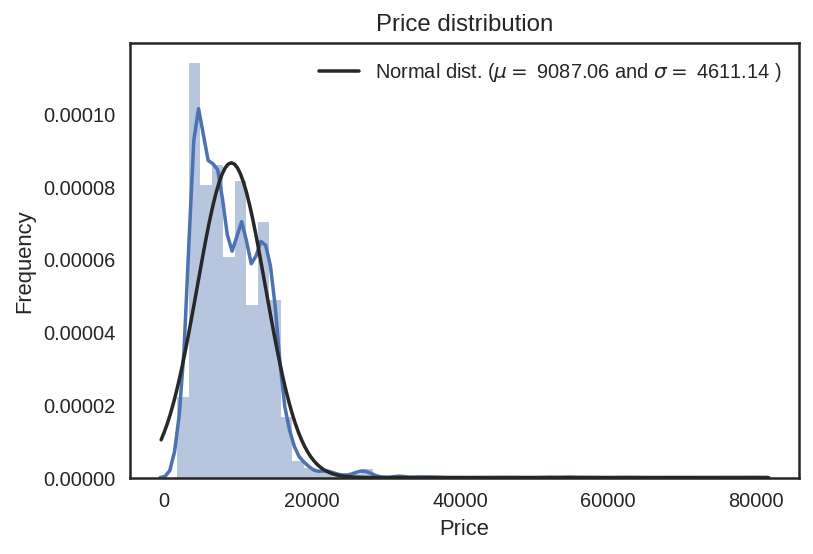

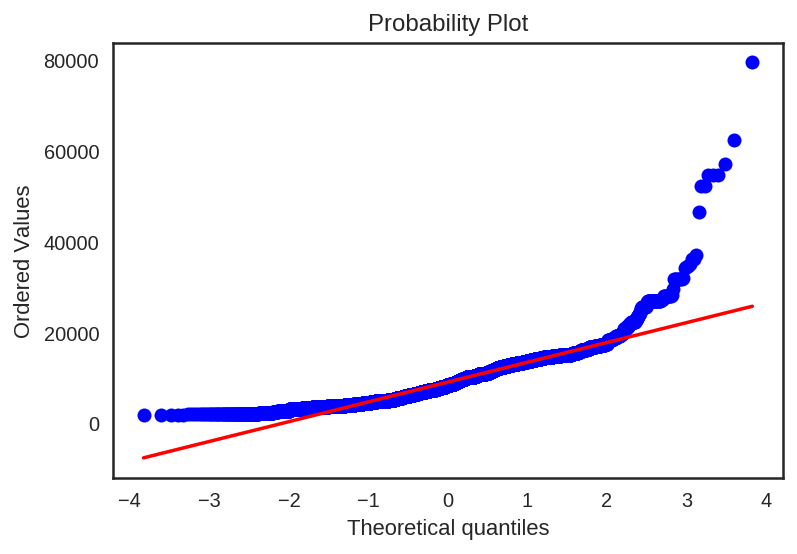

Skewness: 1.812552
Kurtosis: 13.303330


In [0]:
sns.distplot(df['Price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['Price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

fig = plt.figure()
res = stats.probplot(df['Price'], plot=plt)
plt.show()

print("Skewness: %f" % df['Price'].skew())
print("Kurtosis: %f" % df['Price'].kurt())

In [0]:
df.select_dtypes(include=['object']).columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info'],
      dtype='object')

In [0]:
df.select_dtypes(include=['int64','float64']).columns

Index(['Price'], dtype='object')

In [0]:
cat = len(df.select_dtypes(include=['object']).columns)
num = len(df.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  10 categorical + 1 numerical = 11 features


In [0]:
'''corrmat = df.corr()
k = 5 
cols = corrmat.nlargest(k, 'Price')['Price'].index
cm = np.corrcoef(df[cols].values.T)
print(cols)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()'''
#because allll is categorical

"corrmat = df.corr()\nk = 5 \ncols = corrmat.nlargest(k, 'Price')['Price'].index\ncm = np.corrcoef(df[cols].values.T)\nprint(cols)\nsns.set(font_scale=1.25)\nhm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)\nplt.show()"

In [0]:
ntrain = df.shape[0]
ntest = df2.shape[0]
y_train = df.Price.values
all_data = pd.concat((df,df2)).reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)
print("Train data size is : {}".format(df.shape))
print("Test data size is : {}".format(df2.shape))
print("Combined dataset size is : {}".format(all_data.shape))

Train data size is : (10683, 11)
Test data size is : (2671, 10)
Combined dataset size is : (13354, 10)


In [0]:
# Find Missing Ratio of Dataset
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
Total_Stops,0.007488
Route,0.007488


Text(0.5, 1.0, 'Percent missing data by feature')

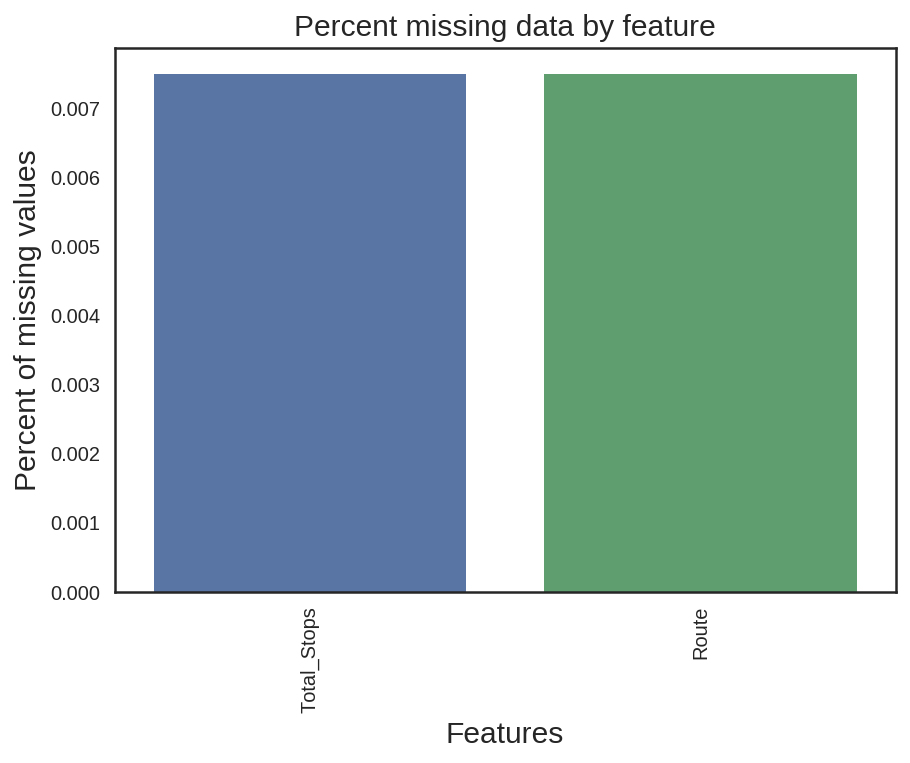

In [0]:
f, ax = plt.subplots(figsize=(7, 5))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [0]:
all_data["Total_Stops"] = all_data["Total_Stops"].fillna("None")
all_data["Route"] = all_data["Route"].fillna("None")



In [0]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [0]:
all_data.columns

Index(['Additional_Info', 'Airline', 'Arrival_Time', 'Date_of_Journey',
       'Dep_Time', 'Destination', 'Duration', 'Route', 'Source',
       'Total_Stops'],
      dtype='object')

In [0]:
from sklearn.preprocessing import LabelEncoder
cols = ('Additional_Info', 'Airline', 'Arrival_Time', 'Date_of_Journey',
       'Dep_Time', 'Destination', 'Duration', 'Route', 'Source',
       'Total_Stops')
# Process columns and apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# Check shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (13354, 10)



 mu = 8.99 and sigma = 0.51



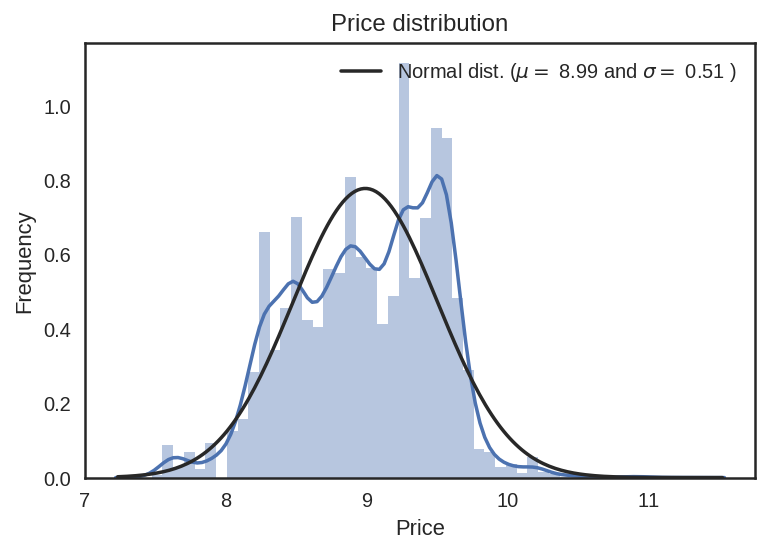

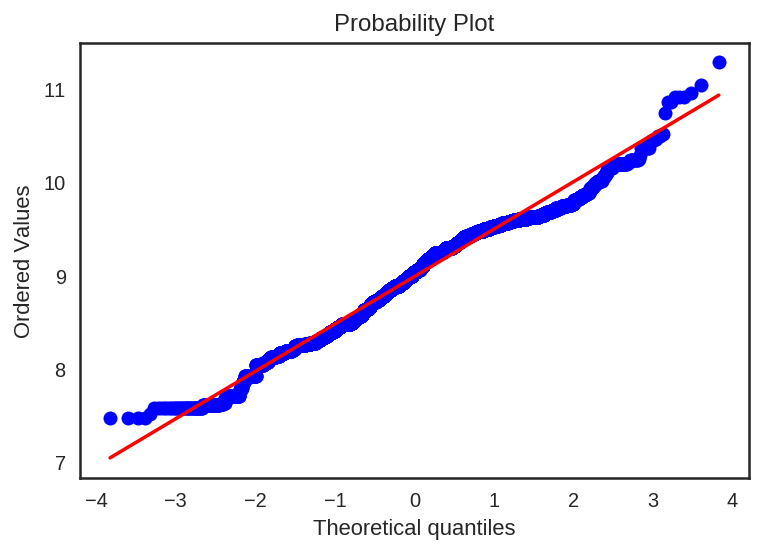

Skewness: -0.254565
Kurtosis: -0.402242


In [0]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["Price"] = np.log1p(df["Price"])

#Check the new distribution 
sns.distplot(df['Price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['Price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

fig = plt.figure()
res = stats.probplot(df['Price'], plot=plt)
plt.show()

y_train = df.Price.values

print("Skewness: %f" % df['Price'].skew())
print("Kurtosis: %f" % df['Price'].kurt())

In [0]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [0]:
y_train.shape

(10683,)

In [0]:
t=train
t['Price']=y_train

In [0]:
t.shape

(10683, 11)

Index(['Price', 'Route', 'Arrival_Time', 'Source', 'Date_of_Journey',
       'Dep_Time', 'Airline', 'Additional_Info', 'Duration', 'Destination'],
      dtype='object')


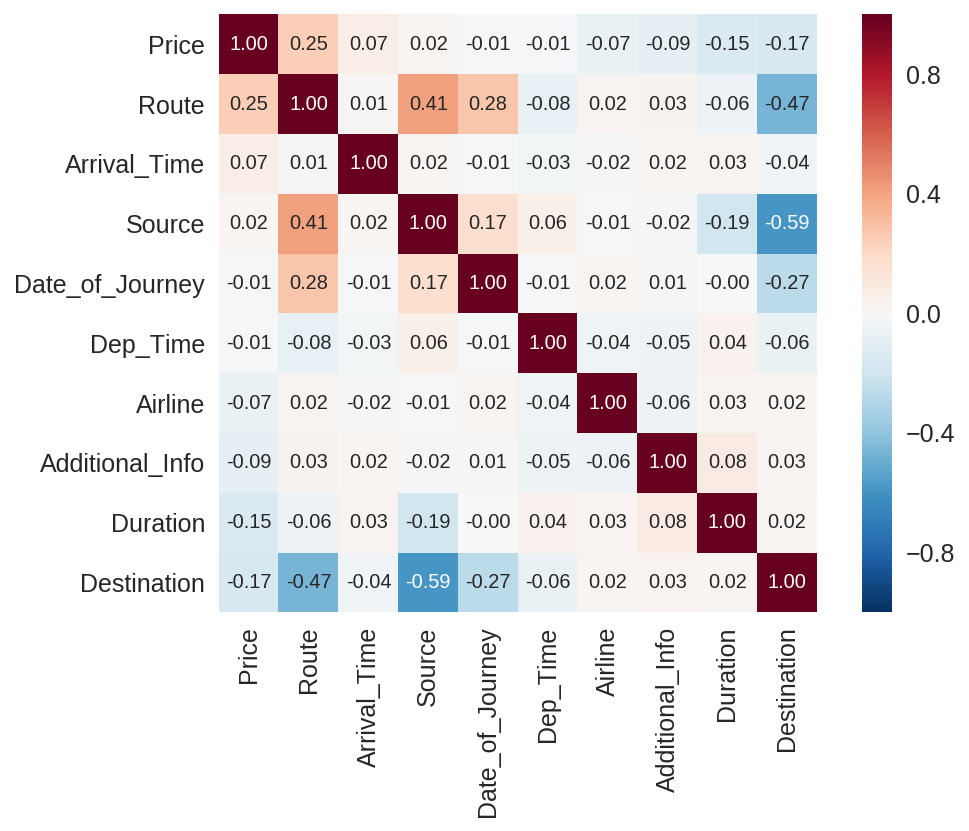

In [0]:
corrmat = t.corr()
k = 10 
cols = corrmat.nlargest(k, 'Price')['Price'].index
cm = np.corrcoef(t[cols].values.T)
print(cols)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
#because allll is categorical

In [0]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [0]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [0]:
lasso = make_pipeline(RobustScaler(),Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state =7)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [0]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.3617 (0.0057)

ElasticNet score: 0.3617 (0.0057)

Kernel Ridge score: 0.2808 (0.0061)

Gradient Boosting score: 0.1344 (0.0041)

Xgboost score: 0.1309 (0.0021)

LGBM score: 0.1809 (0.0033)



In [0]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [0]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.2570 (0.0051)



In [0]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(clf)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
        # Now train the cloned  meta-model using the out-of-fold predictions
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
             

In [0]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1347 (0.0043)


In [0]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [0]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.11135641889439185


In [0]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.10518080425018962


In [0]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.1755464709751295


In [0]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.10 + lgb_train_pred*0.20 ))

RMSLE score on train data:
0.11689719997733941


In [0]:
Stacked = 1/(0.1347)
XGBoost = 1/(0.1309)
LGBM = 1/(0.1809)
Sum = Stacked + XGBoost + LGBM
Stacked = Stacked/Sum
XGBoost = XGBoost/Sum
LGBM = LGBM/Sum
print(Stacked, XGBoost, LGBM)

0.36053704616388094 0.37100336224808833 0.26845959158803073


In [0]:
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*Stacked +
               xgb_train_pred*XGBoost + lgb_train_pred*LGBM))

RMSLE score on train data:
0.11768476486094183


In [0]:
ensemble = stacked_pred*Stacked + xgb_pred*XGBoost + lgb_pred*LGBM


In [0]:

df3['Price'][0]
df3.columns

Index(['Price'], dtype='object')

In [0]:
sub = pd.DataFrame()
writer = pd.ExcelWriter('output.xlsx')

#sub[' '] = test_ID
sub['Price'] = ensemble
sub.to_csv('submission.csv',index=False)
sub.to_excel(writer,'Sheet1')
writer.save()

In [0]:
ho=pd.read_csv('submission.csv')
ho.head()

,Price
0,13830.238520
1,4708.085538
2,11591.168868
3,10148.317796
4,3825.444576
